# Set up paths

In [1]:
# Specify the lib path
lib_path<-paste(getwd(),'/hana_reanalysis_lib_r42',sep='')
print(lib_path)

# Set the path
.libPaths(lib_path)
.libPaths()

#Set the vis device
setHook(packageEvent("grDevices", "onLoad"),
function(...) grDevices::X11.options(type='cairo'))
options(device='x11')

[1] "/v-data2/matt_davenport/HaNa_RE/HaNa_Reanalysis/hana_reanalysis_lib_r42"


[1] "/v-data2/matt_davenport/HaNa_RE/HaNa_Reanalysis/hana_reanalysis_lib_r42"
[2] "/home/mdavenport/bin/R4.2.1/R-4.2.1/library"

# 6 - Core gene analysis

In [2]:
library(tidyverse)
library(WGCNA)
library(ggpubr)

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor




In [3]:
nets <- readRDS('1_wgcna_recut_nets.rds')
fpkm <- nets$input_data$fpkm %>% as_tibble(rownames='sample_id')

hana_design <- read.csv('hana_variables_by_sample.csv', header=TRUE, stringsAsFactors=FALSE)

#remove those samples I had to remove before
hana_design <- hana_design %>% filter(!sample_id %in% c("fv_ra_2", "mv_hvc_1")) %>% as_tibble

In [4]:
names(nets$input_data)

[1] "fpkm"        "unrecut_net"

In [5]:
head(fpkm)
head(hana_design)

sample_id A1CF       A2M      A4GNT      AAAS     AACS     AADAC     
1 fe_an_1   0.00000000 7.093980 0.00000000 7.692193 49.32907 0.03223515
2 fe_an_2   0.04557418 4.603331 0.00000000 7.222035 44.81534 0.00000000
3 fe_an_3   0.02213098 6.060817 0.00000000 6.012078 37.57134 0.00000000
4 fe_ax_1   0.00000000 9.463016 0.06496191 4.592011 22.15344 0.03798045
5 fe_ax_2   0.04701613 6.334622 0.15844851 9.687336 19.60612 0.04631903
6 fe_ax_3   0.00000000 5.639964 0.00000000 6.831030 16.69971 0.00000000
  AADAT     AAGAB    AAK1     ⋯ ZSWIM7   ZSWIM8   ZUP1      ZW10     ZWILCH  
1 0.6634673 31.15091 39.58131 ⋯ 12.36159 2.094811 11.435813 4.783891 2.111552
2 0.3810742 33.07874 35.77192 ⋯ 19.13082 1.606932  7.308235 5.893162 3.651458
3 1.1488581 32.89971 43.11340 ⋯ 17.90711 2.392109  7.846031 4.413440 3.580818
4 1.0960165 26.90928 29.74793 ⋯ 14.90511 3.796637 15.475760 6.061926 3.309983
5 0.3669225 28.41250 35.30265 ⋯ 17.87317 3.396628 11.164825 5.079860 2.392111
6 1.3223168 35.06826 32.36720 ⋯ 11.81573 5.945649  8.521584 2.561196 3.114575
  ZXDC     ZYG11B   ZYX      ZZEF1    ZZZ3     
1 3.601635 50.19418 8.886919 6.180941  8.451389
2 2.799674 60.55626 8.327203 5.846237  6.702416
3 2.817938 52.33897 8.748009 8.576732  8.207267
4 3.197201 16.52732 7.346755 5.679001 10.680909
5 3.205963 14.71874 6.689560 4.276965  8.967043
6 2.933240 12.00139 5.899499 6.239419 12.185660

sample_id animal sex dose pallia region song_capable node song_system
1 fe_hvc_1  a      f   e    nido   hvc    y            dn   y          
2 fe_hvc_2  b      f   e    nido   hvc    y            dn   y          
3 fe_hvc_3  c      f   e    nido   hvc    y            dn   y          
4 fe_pln_1  a      f   e    nido   pln    n            dn   n          
5 fe_pln_2  b      f   e    nido   pln    n            dn   n          
6 fe_pln_3  c      f   e    nido   pln    n            dn   n

In [6]:
fpkm <- fpkm %>% pivot_longer(-one_of('sample_id'),
                              names_to='gene_id',
                              values_to='fpkm')
head(fpkm)

sample_id gene_id fpkm       
1 fe_an_1   A1CF     0.00000000
2 fe_an_1   A2M      7.09397986
3 fe_an_1   A4GNT    0.00000000
4 fe_an_1   AAAS     7.69219347
5 fe_an_1   AACS    49.32906824
6 fe_an_1   AADAC    0.03223515

In [7]:
fpkm <- left_join(hana_design,fpkm,by='sample_id')
head(fpkm)

sample_id animal sex dose pallia region song_capable node song_system gene_id
1 fe_hvc_1  a      f   e    nido   hvc    y            dn   y           A1CF   
2 fe_hvc_1  a      f   e    nido   hvc    y            dn   y           A2M    
3 fe_hvc_1  a      f   e    nido   hvc    y            dn   y           A4GNT  
4 fe_hvc_1  a      f   e    nido   hvc    y            dn   y           AAAS   
5 fe_hvc_1  a      f   e    nido   hvc    y            dn   y           AACS   
6 fe_hvc_1  a      f   e    nido   hvc    y            dn   y           AADAC  
  fpkm      
1  0.0171736
2  7.1346124
3  0.0000000
4  8.5950316
5 57.9439117
6  0.0986940

## Now the mod memberships

In [8]:
mod_mem <- readRDS('4_mod_membership_all_genes.rds')
head(mod_mem)

A           B           C           D           E           F           
1 -0.03370932  0.18224771 -0.09239870 -0.15846667  0.17859488  0.001863475
2  0.02510845 -0.36403524  0.30267066 -0.08856526  0.44178052  0.037101574
3  0.18255477  0.10507450 -0.10350080 -0.06411247 -0.08134665 -0.112865812
4 -0.17604402 -0.36389087  0.33743185  0.76031742  0.05085780 -0.326007923
5 -0.72859604  0.26244931  0.29321445  0.02052947  0.04168985  0.032170986
6 -0.07273316  0.09715425  0.02042227  0.07404382 -0.05979183 -0.064351647
  G           H           I           J           K           L          
1  0.12842694 -0.07431761 -0.07838895 -0.04283075 -0.11005667 -0.25708316
2 -0.05202142  0.13264074  0.33842222 -0.05095856 -0.15834949  0.30518858
3  0.10047994 -0.04726497 -0.11964807  0.50213499  0.05178730  0.09712287
4 -0.07671473 -0.15493875 -0.06018514  0.15980198  0.14182718 -0.10599198
5  0.27472125 -0.06501581 -0.13804126 -0.04817724  0.07641915 -0.04250240
6  0.10828197 -0.02043833 -0.14172340 -0.13060679 -0.07616428 -0.02772431
  gene_id me_assigned
1 A1CF    X          
2 A2M     X          
3 A4GNT   J          
4 AAAS    D          
5 AACS    A          
6 AADAC   X

### I'd like to look at the differences between X and not X assigned genes real quick, totally not because a reviewer asked for it...

In [9]:
assigned_for_fpkm <- mod_mem %>% dplyr::select(gene_id,me_assigned)

In [10]:
head(assigned_for_fpkm)

gene_id me_assigned
1 A1CF    X          
2 A2M     X          
3 A4GNT   J          
4 AAAS    D          
5 AACS    A          
6 AADAC   X

In [11]:
fpkm_mod_mem <- fpkm %>% left_join(assigned_for_fpkm, by='gene_id') %>% mutate(is_X = me_assigned=='X')
fpkm_mod_mem %>% head

sample_id animal sex dose pallia region song_capable node song_system gene_id
1 fe_hvc_1  a      f   e    nido   hvc    y            dn   y           A1CF   
2 fe_hvc_1  a      f   e    nido   hvc    y            dn   y           A2M    
3 fe_hvc_1  a      f   e    nido   hvc    y            dn   y           A4GNT  
4 fe_hvc_1  a      f   e    nido   hvc    y            dn   y           AAAS   
5 fe_hvc_1  a      f   e    nido   hvc    y            dn   y           AACS   
6 fe_hvc_1  a      f   e    nido   hvc    y            dn   y           AADAC  
  fpkm       me_assigned is_X 
1  0.0171736 X            TRUE
2  7.1346124 X            TRUE
3  0.0000000 J           FALSE
4  8.5950316 D           FALSE
5 57.9439117 A           FALSE
6  0.0986940 X            TRUE

In [12]:
X_obs <- fpkm_mod_mem %>% filter(is_X==TRUE)
non_X_obs <- fpkm_mod_mem %>% filter(is_X==FALSE)

X_obs$fpkm %>% median()
non_X_obs$fpkm %>% median()
(non_X_obs$fpkm %>% median())/(X_obs$fpkm %>% median())
X_obs$fpkm %>% mean()
non_X_obs$fpkm %>% mean()
(non_X_obs$fpkm %>% mean())/(X_obs$fpkm %>% mean())

[1] 0.223581

[1] 4.855534

[1] 21.71712

[1] 6.410544

[1] 30.45036

[1] 4.750044

In [13]:
max_expression_median_gene<- fpkm_mod_mem %>% filter(is_X==FALSE) %>% dplyr::select(fpkm,gene_id) %>% group_by(gene_id) %>% summarize(av=max(fpkm)) %>% ungroup %>% dplyr::select(av) %>% unlist %>% median()
max_expression_median_gene_X<- fpkm_mod_mem %>% filter(is_X==TRUE) %>% dplyr::select(fpkm,gene_id) %>% group_by(gene_id) %>% summarize(av=max(fpkm)) %>% ungroup %>% dplyr::select(av) %>% unlist %>% median()
max_expression_median_gene/max_expression_median_gene_X

[1] 7.759385

In [14]:
fpkm_mod_mem %>% filter(is_X==TRUE) %>% dplyr::select(fpkm,gene_id) %>% group_by(gene_id) %>% summarize(av=max(fpkm)) %>% ungroup %>% dplyr::select(av) %>% unlist %>% median()

[1] 1.522779

In [15]:
4.8555/.2235

[1] 21.72483

### Back to out regularly scheduled programmming (see what I did there?)

In [16]:
mod_mem <- mod_mem %>% pivot_longer(-one_of(c('gene_id','me_assigned')),
                                    names_to='module',
                                    values_to='membership')
head(mod_mem)

gene_id me_assigned module membership  
1 A1CF    X           A      -0.033709315
2 A1CF    X           B       0.182247714
3 A1CF    X           C      -0.092398699
4 A1CF    X           D      -0.158466666
5 A1CF    X           E       0.178594884
6 A1CF    X           F       0.001863475

## First thing is to make a list of tibbles, subset from fpkm. One for each set within which I'm computing gene significance.

In [59]:
gen_list <- list()

gen_list$m_an <- fpkm %>% filter(sex=='m') %>% filter(node=='an')
gen_list$f_an <- fpkm %>% filter(sex=='f') %>% filter(node=='an')

gen_list$m_dn <- fpkm %>% filter(sex=='m') %>% filter(node=='dn')
gen_list$f_dn <- fpkm %>% filter(sex=='f') %>% filter(node=='dn')

gen_list$m_la <- fpkm %>% filter(sex=='m') %>% filter(node=='la')
gen_list$f_la <- fpkm %>% filter(sex=='f') %>% filter(node=='la')

gen_list$m_str <- fpkm %>% filter(sex=='m') %>% filter(node=='str')
gen_list$f_str <- fpkm %>% filter(sex=='f') %>% filter(node=='str')

gen_list$f_an_v <- fpkm %>% filter(sex=='f') %>% filter(node=='an') %>% filter(dose=='v')
gen_list$f_dn_v <- fpkm %>% filter(sex=='f') %>% filter(node=='dn') %>% filter(dose=='v')  
gen_list$f_la_v <- fpkm %>% filter(sex=='f') %>% filter(node=='la') %>% filter(dose=='v')  
gen_list$f_str_v <- fpkm %>% filter(sex=='f') %>% filter(node=='str') %>% filter(dose=='v')  

gen_list$fm_lman_v <- fpkm %>% filter(region=='lman') %>% filter(dose=='v')
gen_list$fm_hvc_v <-  fpkm %>% filter(region=='hvc') %>% filter(dose=='v')
gen_list$fm_ra_v <-   fpkm %>% filter(region=='ra') %>% filter(dose=='v')
gen_list$fm_ax_v <-   fpkm %>% filter(region=='ax') %>% filter(dose=='v')

gen_list$f_lman <- fpkm %>% filter(region=='lman') %>% filter(sex=='f')
gen_list$f_hvc <-  fpkm %>% filter(region=='hvc') %>% filter(sex=='f')
gen_list$f_ra <- fpkm %>% filter(region=='ra') %>% filter(sex=='f')
gen_list$f_ax <- fpkm %>% filter(region=='ax') %>% filter(sex=='f')

gen_list$f_dn_2 <- fpkm %>% filter(sex=='f') %>% filter(node=='dn') %>% filter(dose == 'e' | region=='pln')



names(gen_list)
head(gen_list$fm_ax_v)

saveRDS(object = gen_list,file = 'gen_list.rds')


[1] "m_an"      "f_an"      "m_dn"      "f_dn"      "m_la"      "f_la"     
 [7] "m_str"     "f_str"     "f_an_v"    "f_dn_v"    "f_la_v"    "f_str_v"  
[13] "fm_lman_v" "fm_hvc_v"  "fm_ra_v"   "fm_ax_v"   "f_lman"    "f_hvc"    
[19] "f_ra"      "f_ax"      "f_dn_2"

sample_id animal sex dose pallia region song_capable node song_system gene_id
1 fv_ax_1   d      f   v    str    ax     n            str  y           A1CF   
2 fv_ax_1   d      f   v    str    ax     n            str  y           A2M    
3 fv_ax_1   d      f   v    str    ax     n            str  y           A4GNT  
4 fv_ax_1   d      f   v    str    ax     n            str  y           AAAS   
5 fv_ax_1   d      f   v    str    ax     n            str  y           AACS   
6 fv_ax_1   d      f   v    str    ax     n            str  y           AADAC  
  fpkm       
1  0.11432586
2  7.48376642
3  0.00000000
4  3.76938836
5 21.97611711
6  0.06257265

In [18]:
#I need a list of all the genes 
genes <- unique(gen_list$m_an$gene_id)
names(genes) <- genes

## Do a loop run the stats. Doing it in one shot with corAndP

In [19]:
a <- gen_list %>% lapply(function(sample_set){
    res_tbl <- genes %>% lapply(function(gene){
        x <- sample_set %>% filter(gene_id == gene)
        corAndPvalue(x$fpkm, x$song_capable=='y') %>% lapply(as.numeric)
    }) 
})

### wrangle into a nice tibble, takes a while

In [20]:
song_cap_res_tbls <- a %>% lapply(function(tbl){
    
    res <- tbl %>% t
    res <-res %>% lapply(as.data.frame)
    names(res) <- names(tbl)
    res <- names(res) %>% lapply(function(ge){res[[ge]] %>% mutate(gene_id=ge)})
    res <- res %>% purrr::reduce(rbind) %>% mutate(q=p.adjust(p, method='fdr'))
})

head(song_cap_res_tbls$f_an)

cor        p         Z          t         nObs gene_id q        
1 -0.3076009 0.3307403 -1.0052674 1.0222845 12   A1CF    0.7384502
2  0.1851011 0.5646563  0.5921669 0.5956338 12   A2M     0.8353087
3         NA        NA         NA        NA 12   A4GNT          NA
4 -0.6579593 0.0200281 -2.4956904 2.7629514 12   AAAS    0.5824218
5 -0.4553904 0.1368356 -1.5541967 1.6175268 12   AACS    0.6256573
6 -0.2519178 0.4295977 -0.8141585 0.8231828 12   AADAC   0.7890963

In [21]:
song_cap_res_tbls <- song_cap_res_tbls %>% lapply(left_join,mod_mem,by='gene_id')


In [22]:
head(song_cap_res_tbls$f_dn)

cor        p         Z          t         nObs gene_id q         me_assigned
1 -0.2546008 0.4245329 -0.8232244 0.8325543 12   A1CF    0.9797267 X          
2 -0.2546008 0.4245329 -0.8232244 0.8325543 12   A1CF    0.9797267 X          
3 -0.2546008 0.4245329 -0.8232244 0.8325543 12   A1CF    0.9797267 X          
4 -0.2546008 0.4245329 -0.8232244 0.8325543 12   A1CF    0.9797267 X          
5 -0.2546008 0.4245329 -0.8232244 0.8325543 12   A1CF    0.9797267 X          
6 -0.2546008 0.4245329 -0.8232244 0.8325543 12   A1CF    0.9797267 X          
  module membership  
1 A      -0.033709315
2 B       0.182247714
3 C      -0.092398699
4 D      -0.158466666
5 E       0.178594884
6 F       0.001863475

In [23]:
options(repr.plot.width=12.5, repr.plot.height=10)
cor_cor_plot <- function(tbl,modu,rect_col){
tbl %>% filter(module==modu) %>% filter(me_assigned!='X') %>%
    
    ggplot(aes(x=membership,
               y=cor,
               fill=me_assigned,
               size=me_assigned==modu,
               color=me_assigned==modu)) + 
    geom_rect(aes(xmin = .5^.5, xmax = 1, ymin = .5^.5, ymax = 1),
               fill = rect_col, color='black', size = .75) +
    
    geom_point(shape=21)+
    xlim(-1,1) + ylim(-1,1)+
    scale_color_manual(values=c('grey','black'))+
    geom_smooth(method = "lm",color='black',fill='grey',size=2)+
    scale_fill_brewer('Module',palette = 'Set3')+
    scale_size_manual(values=c(2,3))+
    theme_grey(base_size=25) + 
    xlab(modu)+ylab('VL Capable')+guides(size=FALSE,color=FALSE)+
    guides(fill = guide_legend(override.aes = list(size=10)))
    
    }



In [24]:
g_legend<-function(a.gplot){
  tmp <- ggplot_gtable(ggplot_build(a.gplot))
  leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)} 

m_dn_g<-cor_cor_plot(song_cap_res_tbls$m_dn,'G',"#1b9e77") + ggtitle('Male VL:\nHVC vs. DN') +theme(plot.title = element_text(size=30),legend.position='none')+ylab('Vocal Learning')
f_dn_g<-cor_cor_plot(song_cap_res_tbls$f_dn_2,'G',"#d95f02") + ggtitle('Female VL: \nE2-HVC vs. DN & Veh-HVC') +theme(plot.title = element_text(size=30),legend.position='none') +ylab('')
fm_hvc_v<-cor_cor_plot(song_cap_res_tbls$fm_hvc_v,'G',"#7570b3") + ggtitle('Untreated VL + Sex: \nMale-HVC vs. Female-HVC') +theme(plot.title = element_text(size=30),legend.position='none')+ylab('')
f_hvc<-cor_cor_plot(song_cap_res_tbls$f_hvc,'G',"#e7298a") + ggtitle('Female VL + E2: \nVeh-HVC vs. E2-HVC') +ylab('') +theme(plot.title = element_text(size=30))

lgnd <-  g_legend(f_hvc)

f_hvc <- f_hvc + theme(legend.position='none')

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 88 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 88 rows containing missing values (geom_point).”


In [25]:
options(repr.plot.width=28+7/4, repr.plot.height=7)
top<-ggarrange(m_dn_g,f_dn_g,fm_hvc_v,f_hvc,lgnd,nrow=1,widths=c(1,1,1,1,.25))

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 95 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 95 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 92 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 92 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 123 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 123 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 88 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 88 rows containing missing values (geom_point).”


Warning message in grid.Call.graphics(C_polygon, x$x, x$y, index):
“semi-transparency is not supported on this device: reported only once per page”


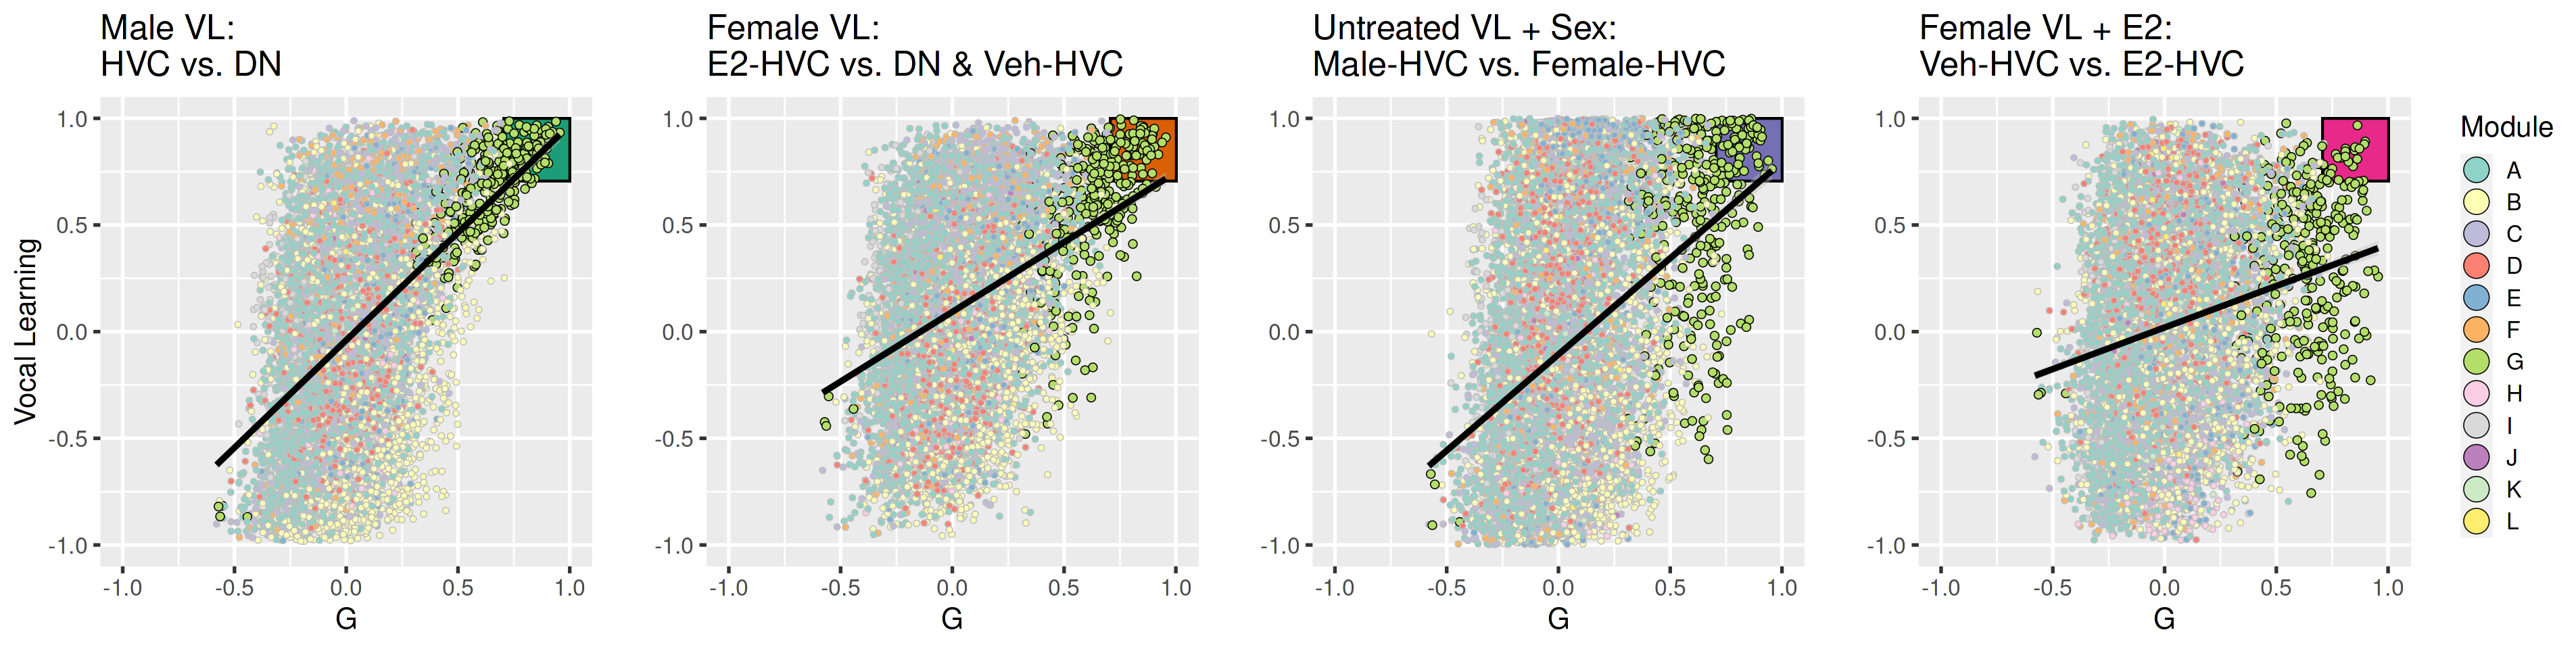

In [26]:
options(repr.plot.width=30+7/4, repr.plot.height=8)

top

In [27]:
library(ggrepel)

In [28]:
options(repr.plot.width=12.5, repr.plot.height=10)

zoom_cor_cor_plot <- function(tbl,modu,bottom_left,top_right,rect_col){
    tbl %>% filter(module==modu) %>% filter(me_assigned!='X') %>% 
    
    ggplot(aes(x=membership,
               y=cor)) + 
    geom_label_repel(aes(label=gene_id),size=6,fill='white', color='black',max.overlaps = Inf)+
    xlim(bottom_left[1],top_right[1]) +
    ylim(bottom_left[2],top_right[2])+
    theme_grey(base_size=25) + 
    xlab(modu)+ylab('VL Capable')+
    guides(fill = guide_legend(override.aes = list(size=10)))+
    theme(panel.background = element_rect(fill =rect_col),panel.grid = element_blank())
}



In [29]:
m_dn_zoom_p<-zoom_cor_cor_plot(song_cap_res_tbls$m_dn,'G',c(.5^.5,.5^.5),c(1,1),"#1b9e77") +theme(legend.position = 'none') +xlab('')+ylab('')
f_dn_zoom_p<-zoom_cor_cor_plot(song_cap_res_tbls$f_dn_2,'G',c(.5^.5,.5^.5),c(1,1),"#d95f02")+theme(legend.position = 'none') +xlab('')+ylab('')
fm_hvc_v_zoom_p<-zoom_cor_cor_plot(song_cap_res_tbls$fm_hvc_v,'G',c(.5^.5,.5^.5),c(1,1),"#7570b3")+theme(legend.position = 'none') +xlab('')+ylab('')
f_hvc_zoom_p<-zoom_cor_cor_plot(song_cap_res_tbls$f_hvc,'G',c(.5^.5,.5^.5),c(1,1),"#e7298a")+theme(legend.position = 'none') +xlab('')+ylab('') 


bottom <- ggarrange(m_dn_zoom_p,f_dn_zoom_p,fm_hvc_v_zoom_p,f_hvc_zoom_p,nrow=2, ncol=2)

Warning message:
“Removed 13185 rows containing missing values (geom_label_repel).”
Warning message:
“Removed 13208 rows containing missing values (geom_label_repel).”
Warning message:
“Removed 13210 rows containing missing values (geom_label_repel).”
Warning message:
“Removed 13251 rows containing missing values (geom_label_repel).”


In [30]:
song_cap_res_tbls$f_dn_2 %>% filter(gene_id=='LRRC2')
.67*.67

cor       p          Z        t        nObs gene_id q         me_assigned
1  0.6705913 0.04804953 2.147866 2.391687 9    LRRC2   0.5146528 G          
2  0.6705913 0.04804953 2.147866 2.391687 9    LRRC2   0.5146528 G          
3  0.6705913 0.04804953 2.147866 2.391687 9    LRRC2   0.5146528 G          
4  0.6705913 0.04804953 2.147866 2.391687 9    LRRC2   0.5146528 G          
5  0.6705913 0.04804953 2.147866 2.391687 9    LRRC2   0.5146528 G          
6  0.6705913 0.04804953 2.147866 2.391687 9    LRRC2   0.5146528 G          
7  0.6705913 0.04804953 2.147866 2.391687 9    LRRC2   0.5146528 G          
8  0.6705913 0.04804953 2.147866 2.391687 9    LRRC2   0.5146528 G          
9  0.6705913 0.04804953 2.147866 2.391687 9    LRRC2   0.5146528 G          
10 0.6705913 0.04804953 2.147866 2.391687 9    LRRC2   0.5146528 G          
11 0.6705913 0.04804953 2.147866 2.391687 9    LRRC2   0.5146528 G          
12 0.6705913 0.04804953 2.147866 2.391687 9    LRRC2   0.5146528 G          
   module membership 
1  A      -0.23984710
2  B       0.01358889
3  C       0.09614309
4  D       0.10350084
5  E       0.28717039
6  F       0.01149377
7  G       0.86282808
8  H      -0.04891734
9  I      -0.20029150
10 J      -0.11275197
11 K      -0.04272559
12 L      -0.07699251

[1] 0.4489

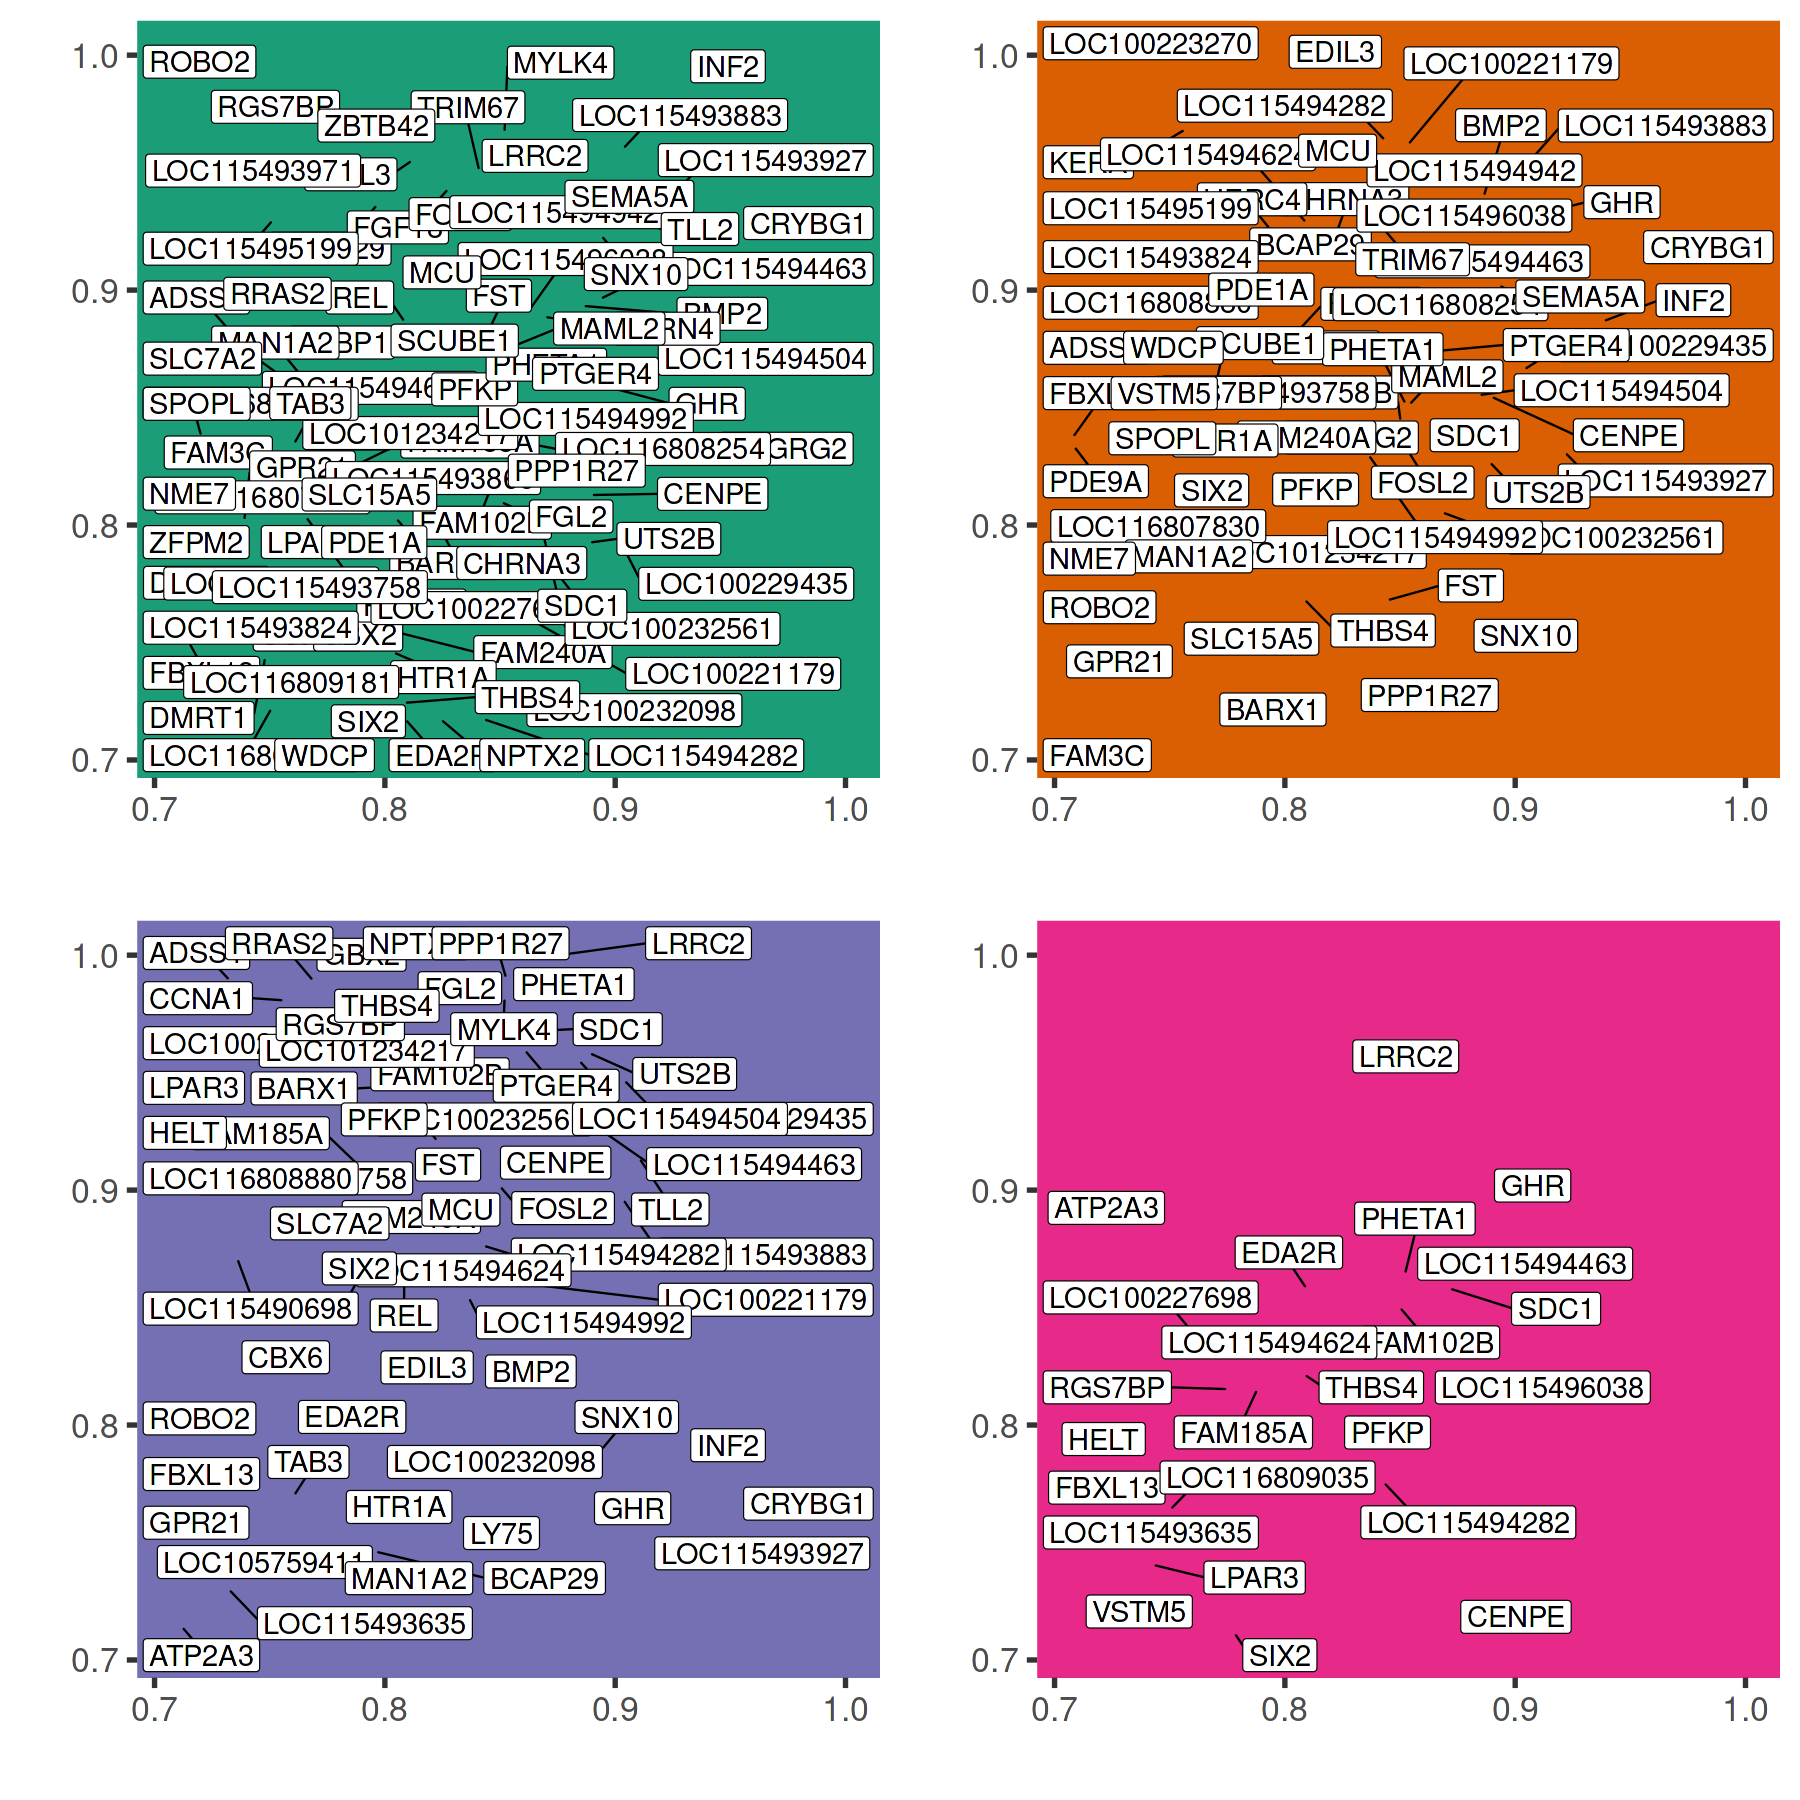

In [31]:
options(repr.plot.width=15, repr.plot.height=15)

bottom

Warning message in grid.Call.graphics(C_polygon, x$x, x$y, index):
“semi-transparency is not supported on this device: reported only once per page”


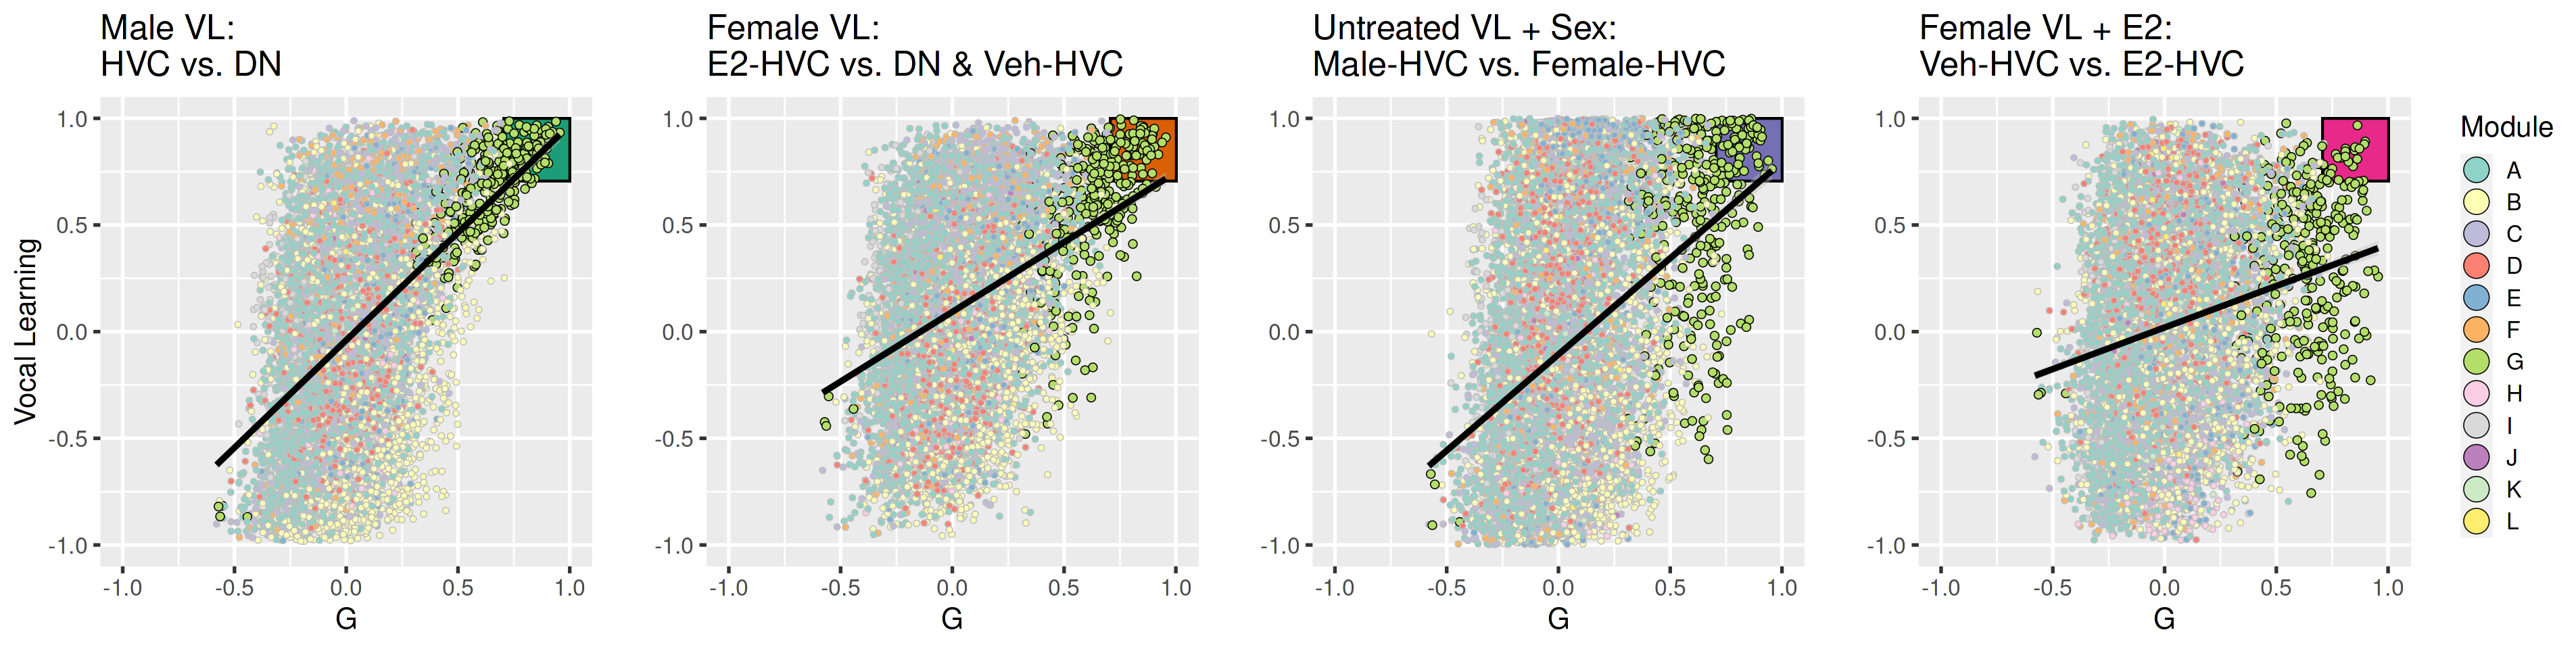

In [32]:
options(repr.plot.width=30+7/4, repr.plot.height=8)
top
ggsave(file='svg_files/fig4_top.svg',plot=top,width = 30+7/4,height = 8)

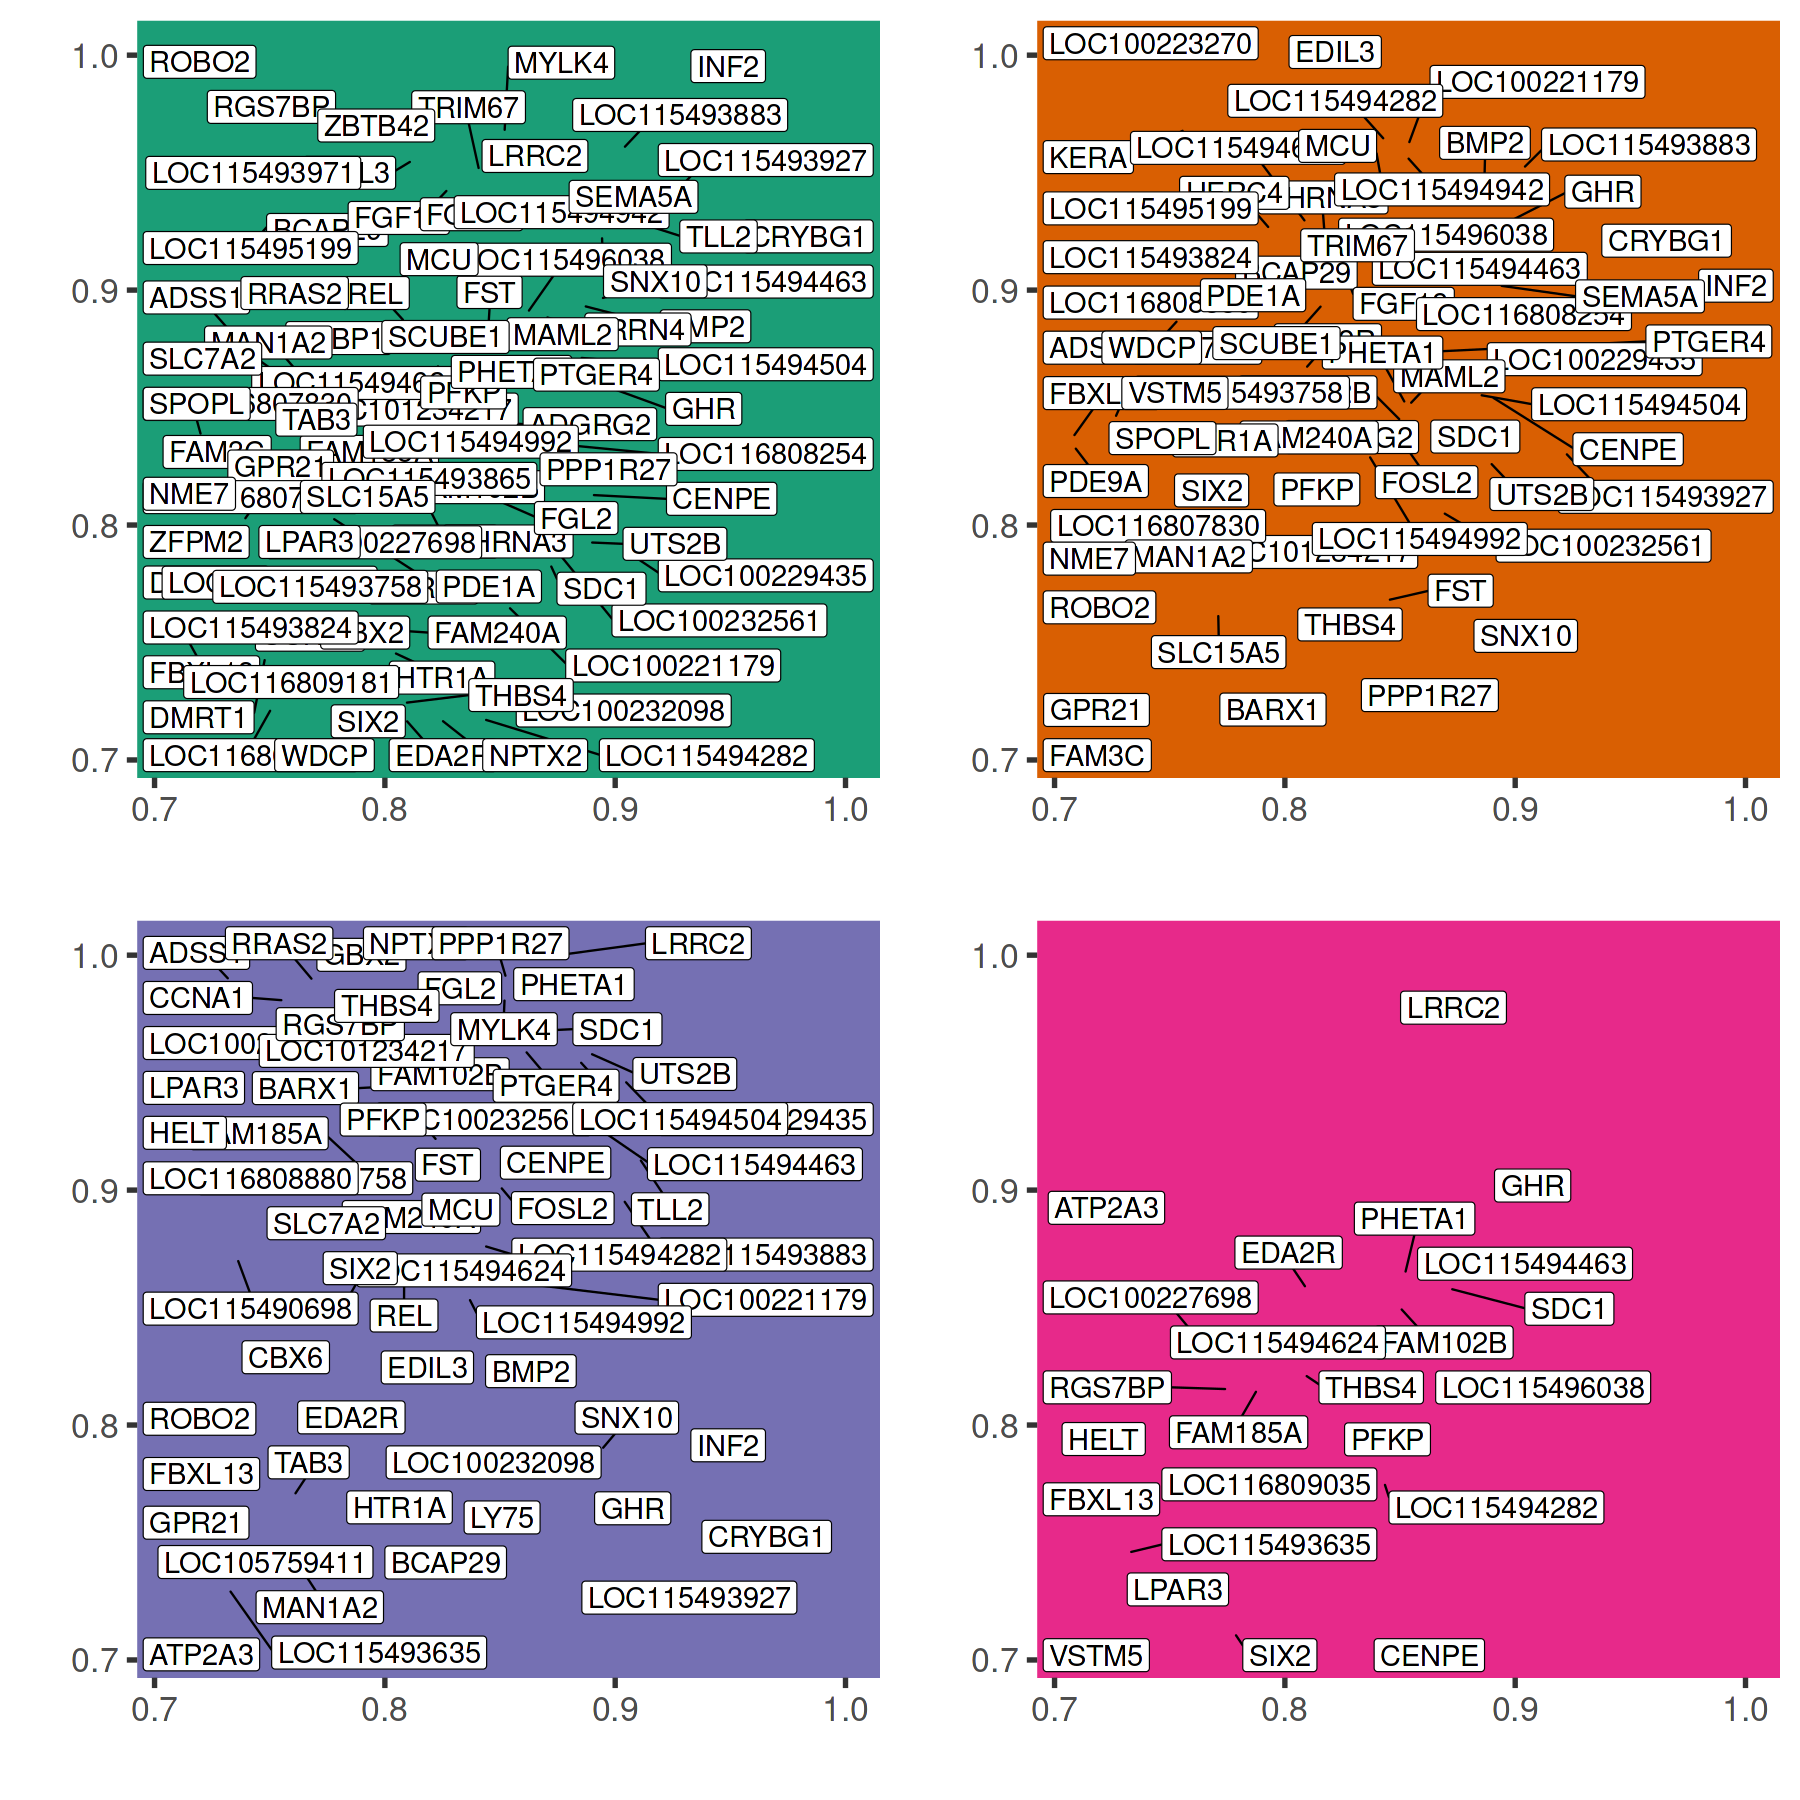

In [33]:
options(repr.plot.width=15, repr.plot.height=15)
bottom
ggsave(file='svg_files/fig4_bottom.svg',plot=bottom,width = 15, height = 15)


In [34]:
zoom_list <- function(tbl,modu,bottom_left=c(-1,-1),top_right=c(1,1)){
    
    tbl %>% filter(module==modu) %>% filter(me_assigned!='X') %>% 
    filter(cor > bottom_left[2]) %>% filter(cor < top_right[2])%>% 
    filter(membership > bottom_left[1]) %>% filter(membership < bottom_left[1] + .5)
}

In [35]:
m_dn_zoom_l<-zoom_list(song_cap_res_tbls$m_dn,'G',c(.5^.5,.5^.5),c(1,1))$gene_id
f_dn_zoom_l<-zoom_list(song_cap_res_tbls$f_dn_2,'G',c(.5^.5,.5^.5),c(1,1))$gene_id
fm_hvc_v_zoom_l<-zoom_list(song_cap_res_tbls$fm_hvc_v,'G',c(.5^.5,.5^.5),c(1,1))$gene_id 
f_hvc_zoom_l<-zoom_list(song_cap_res_tbls$f_hvc,'G',c(.5^.5,.5^.5),c(1,1))$gene_id

In [36]:
library('VennDiagram')

Loading required package: grid

Loading required package: futile.logger


Attaching package: ‘VennDiagram’


The following object is masked from ‘package:ggpubr’:

    rotate




In [37]:
z_list <- rtracklayer::import('/v-data2/matt_davenport/hana_reanalyses/hana_cm_formatted/genome/GCF_008822105.2_bTaeGut2.pat.W.v2_genomic.purged2.gtf') %>%
            as_tibble %>% 
            filter(type=='gene') %>% dplyr::select(one_of(c('gene_id','start', 'seqnames'))) %>% arrange(start) %>%
            mutate(chr=seqnames) %>% mutate(seqnames=NULL) %>% filter(chr=='NC_045027.1')
z_list <- z_list$gene_id


In [38]:
venn_lists <- list(m_dn_zoom_l,f_dn_zoom_l,fm_hvc_v_zoom_l,f_hvc_zoom_l)

names(venn_lists)<-c('Male VL\n','Female VL\t\n','VL + Sex\n','VL + E2\n')


In [39]:
venn.diagram(x=venn_lists,filename = 'svg_files/fig4_core_genes_venn.tiff',output=TRUE,fill=RColorBrewer::brewer.pal(4, "Dark2"),
             height = 2100, width = 2100)

Warning message in tiff(filename = filename, height = height, width = width, units = units, :
“type = "cairo" is unavailable. trying "Xlib"”
Warning message in grid.Call.graphics(C_polygon, x$x, x$y, list(as.integer(seq_along(x$x)))):
“semi-transparency is not supported on this device: reported only once per page”


[1] 1

In [40]:
core_genes <- Reduce(intersect,venn_lists)
all_assigned_genes <- song_cap_res_tbls$f_dn %>% filter(me_assigned!='X') %>% filter(module=='A')
all_assigned_genes<- all_assigned_genes$gene_id

assigned_z_list= intersect(z_list,all_assigned_genes)

core_z_venn_lists <- list(core_genes, assigned_z_list, all_assigned_genes)
names(core_z_venn_lists) <- c(' ', '', '  ')
venn.diagram(x=core_z_venn_lists, filename = 'svg_files/fig4_core_Zchrom_intersect.tiff',
             output=TRUE,fill=c('#b000cf','#4a4a4a','light grey'),
             height = 800, width = 1200
)

Warning message in tiff(filename = filename, height = height, width = width, units = units, :
“type = "cairo" is unavailable. trying "Xlib"”
Warning message in grid.Call.graphics(C_polygon, x$x, x$y, list(as.integer(seq_along(x$x)))):
“semi-transparency is not supported on this device: reported only once per page”


[1] 1

In [41]:
core_genes

[1] "CENPE"        "EDA2R"        "FAM102B"      "FBXL13"       "GHR"         
 [6] "LOC115494282" "LOC115494463" "LOC115494624" "PFKP"         "PHETA1"      
[11] "RGS7BP"       "SDC1"         "SIX2"         "THBS4"

## well thats a bust, maybe I just fade out the non-G colors in those scatter plots. Make the rest of the points grey. 

In [51]:
library(RColorBrewer)
options(repr.plot.width=12.5, repr.plot.height=10)
cor_cor_plot <- function(tbl,modu,rect_col,mod_col){
tbl %>% filter(module==modu) %>% filter(me_assigned!='X') %>%
    
    ggplot(aes(x=membership,
               y=cor,
               fill= me_assigned==modu,
               size= me_assigned==modu,
               color=me_assigned==modu)) + 
    
    geom_rect(aes(xmin = .5^.5, xmax = 1, ymin = .5^.5, ymax = 1),
               fill = rect_col %>% colorspace::darken(amount=.25), color='black', size = .75) +
    
    geom_point(shape=21,stroke=1)+
    xlim(-1,1) + ylim(-1,1)+
    #geom_smooth(method = "lm",color='black',fill='grey',size=2)+
    scale_fill_manual('Module G\nassigned',values=c('darkgrey',mod_col))+
    scale_color_manual(values=c('darkgrey','black'))+
    scale_size_manual(values=c(1,4))+
    theme_grey(base_size=25) + 
    xlab(paste('r - mod',modu,' eigengene',sep=''))+ylab('VL Capable')+guides(size=FALSE,color=FALSE)+
    guides(fill = guide_legend(override.aes = list(size=10)))
    
    }

In [52]:
m_dn_g<-cor_cor_plot(song_cap_res_tbls$m_dn,'G',"#1b9e77",brewer.pal(n=12,name = 'Set3')[7]) + 
    ggtitle('Male VL:\nHVC vs. DN') +
    theme(plot.title = element_text(size=30),legend.position='none')+ylab('r - Vocal Learning Capacity')

f_dn_g<-cor_cor_plot(song_cap_res_tbls$f_dn_2,'G',"#d95f02",brewer.pal(n=12,name = 'Set3')[7]) + 
    ggtitle('Female VL: \nE2-HVC vs. DN & Veh-HVC') +
    theme(plot.title = element_text(size=30),legend.position='none') +ylab('')

fm_hvc_v<-cor_cor_plot(song_cap_res_tbls$fm_hvc_v,'G',"#7570b3",brewer.pal(n=12,name = 'Set3')[7]) + 
    ggtitle('Untreated VL + Sex: \nMale-HVC vs. Female-HVC') +
    theme(plot.title = element_text(size=30),legend.position='none')+ylab('')

f_hvc<-cor_cor_plot(song_cap_res_tbls$f_hvc,'G',"#e7298a",brewer.pal(n=12,name = 'Set3')[7]) + 
    ggtitle('Female VL + E2: \nVeh-HVC vs. E2-HVC') +ylab('') +
    theme(plot.title = element_text(size=30))

lgnd <-  g_legend(f_hvc)

f_hvc <- f_hvc + theme(legend.position='none')

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“Removed 88 rows containing missing values (geom_point).”


Warning message:
“Removed 95 rows containing missing values (geom_point).”
Warning message:
“Removed 92 rows containing missing values (geom_point).”
Warning message:
“Removed 123 rows containing missing values (geom_point).”
Warning message:
“Removed 88 rows containing missing values (geom_point).”


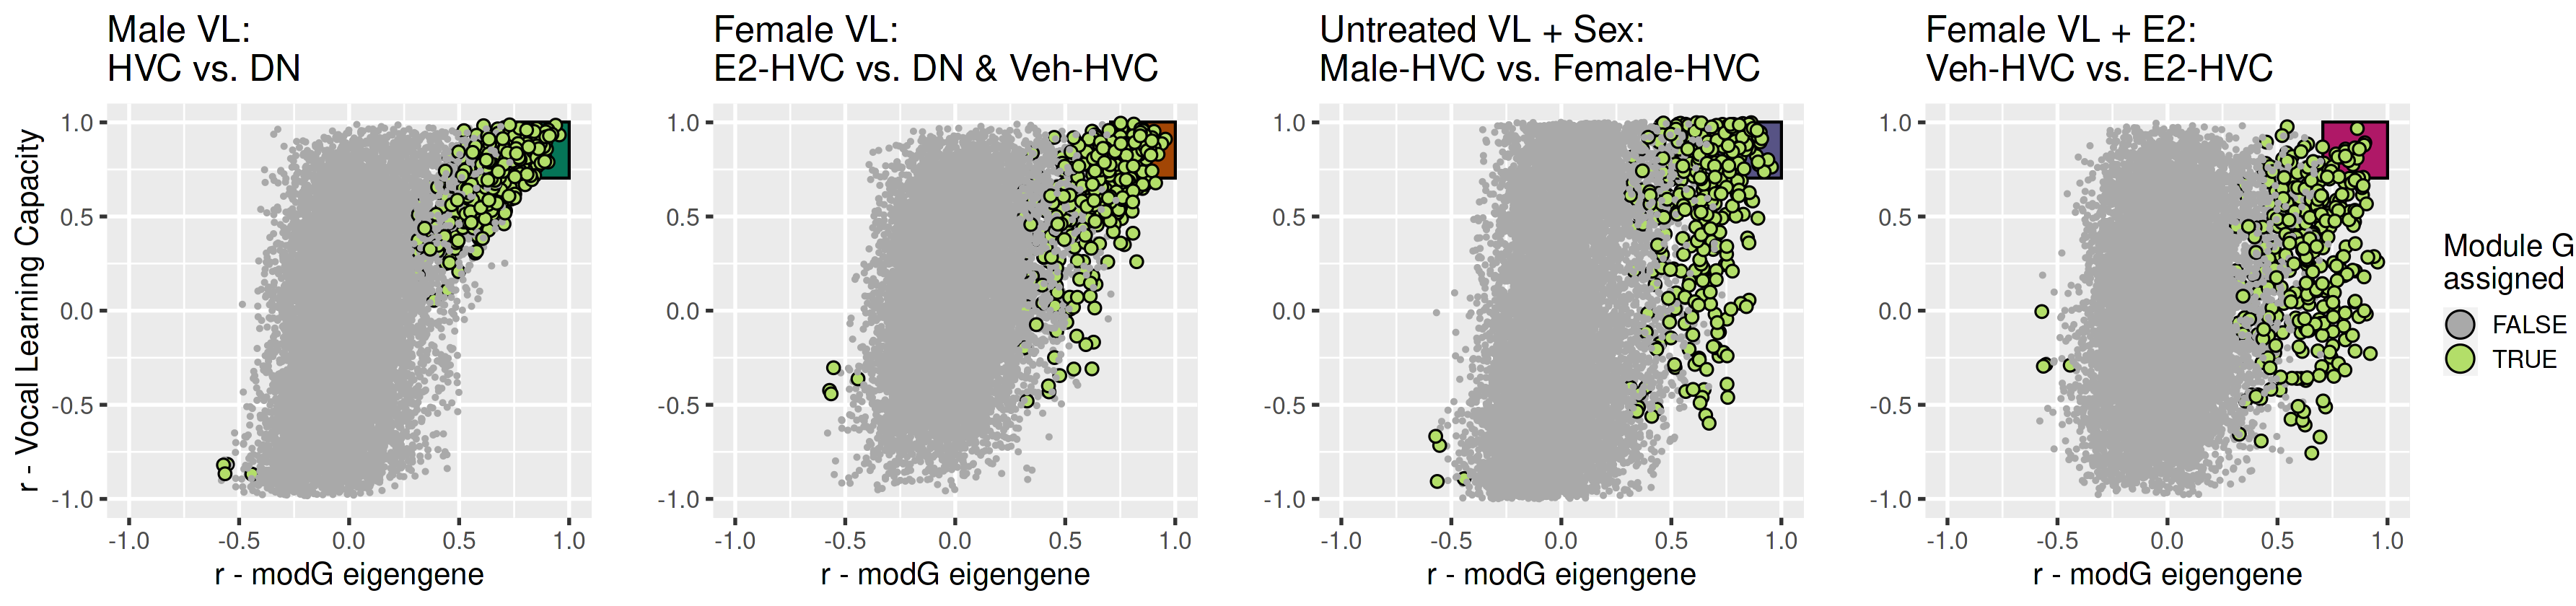

In [53]:
options(repr.plot.width=28+7/4, repr.plot.height=7)
top<-ggarrange(m_dn_g,f_dn_g,fm_hvc_v,f_hvc,lgnd,nrow=1,widths=c(1,1,1,1,.25))
top
ggsave(file='svg_files/fig4_top_new.svg',plot=top,width = 30+7/4,height = 8)


## Statistcal testing for z chromosome enrichment in G core

### assigned genes

In [54]:
phyper(q = 3,
       m = 820,
       n = length(all_assigned_genes)-820,
       k = 14, 
       lower.tail = FALSE, log.p = FALSE)

[1] 0.008783846

### module G genes

In [55]:
mod_mem %>% filter(module=="G")%>% filter(me_assigned=='G') %>% filter(gene_id %in% z_list) %>% dim

[1] 25  4

In [56]:
phyper(q=3,
       m=25,
       n=344-25,
       k=14,
       lower.tail = FALSE, log.p = FALSE)

[1] 0.01330071

### all genes

In [57]:
phyper(q = 3,
       m = length(z_list),
       n = 21040-length(z_list),
       k = 14, 
       lower.tail = FALSE, log.p = FALSE)

[1] 0.004537343

## Lets just look at the expression of these genens

No summary function supplied, defaulting to `mean_se()`

No summary function supplied, defaulting to `mean_se()`

No summary function supplied, defaulting to `mean_se()`

No summary function supplied, defaulting to `mean_se()`

No summary function supplied, defaulting to `mean_se()`

No summary function supplied, defaulting to `mean_se()`

No summary function supplied, defaulting to `mean_se()`

No summary function supplied, defaulting to `mean_se()`

No summary function supplied, defaulting to `mean_se()`

No summary function supplied, defaulting to `mean_se()`

No summary function supplied, defaulting to `mean_se()`

No summary function supplied, defaulting to `mean_se()`

No summary function supplied, defaulting to `mean_se()`

No summary function supplied, defaulting to `mean_se()`

No summary function supplied, defaulting to `mean_se()`



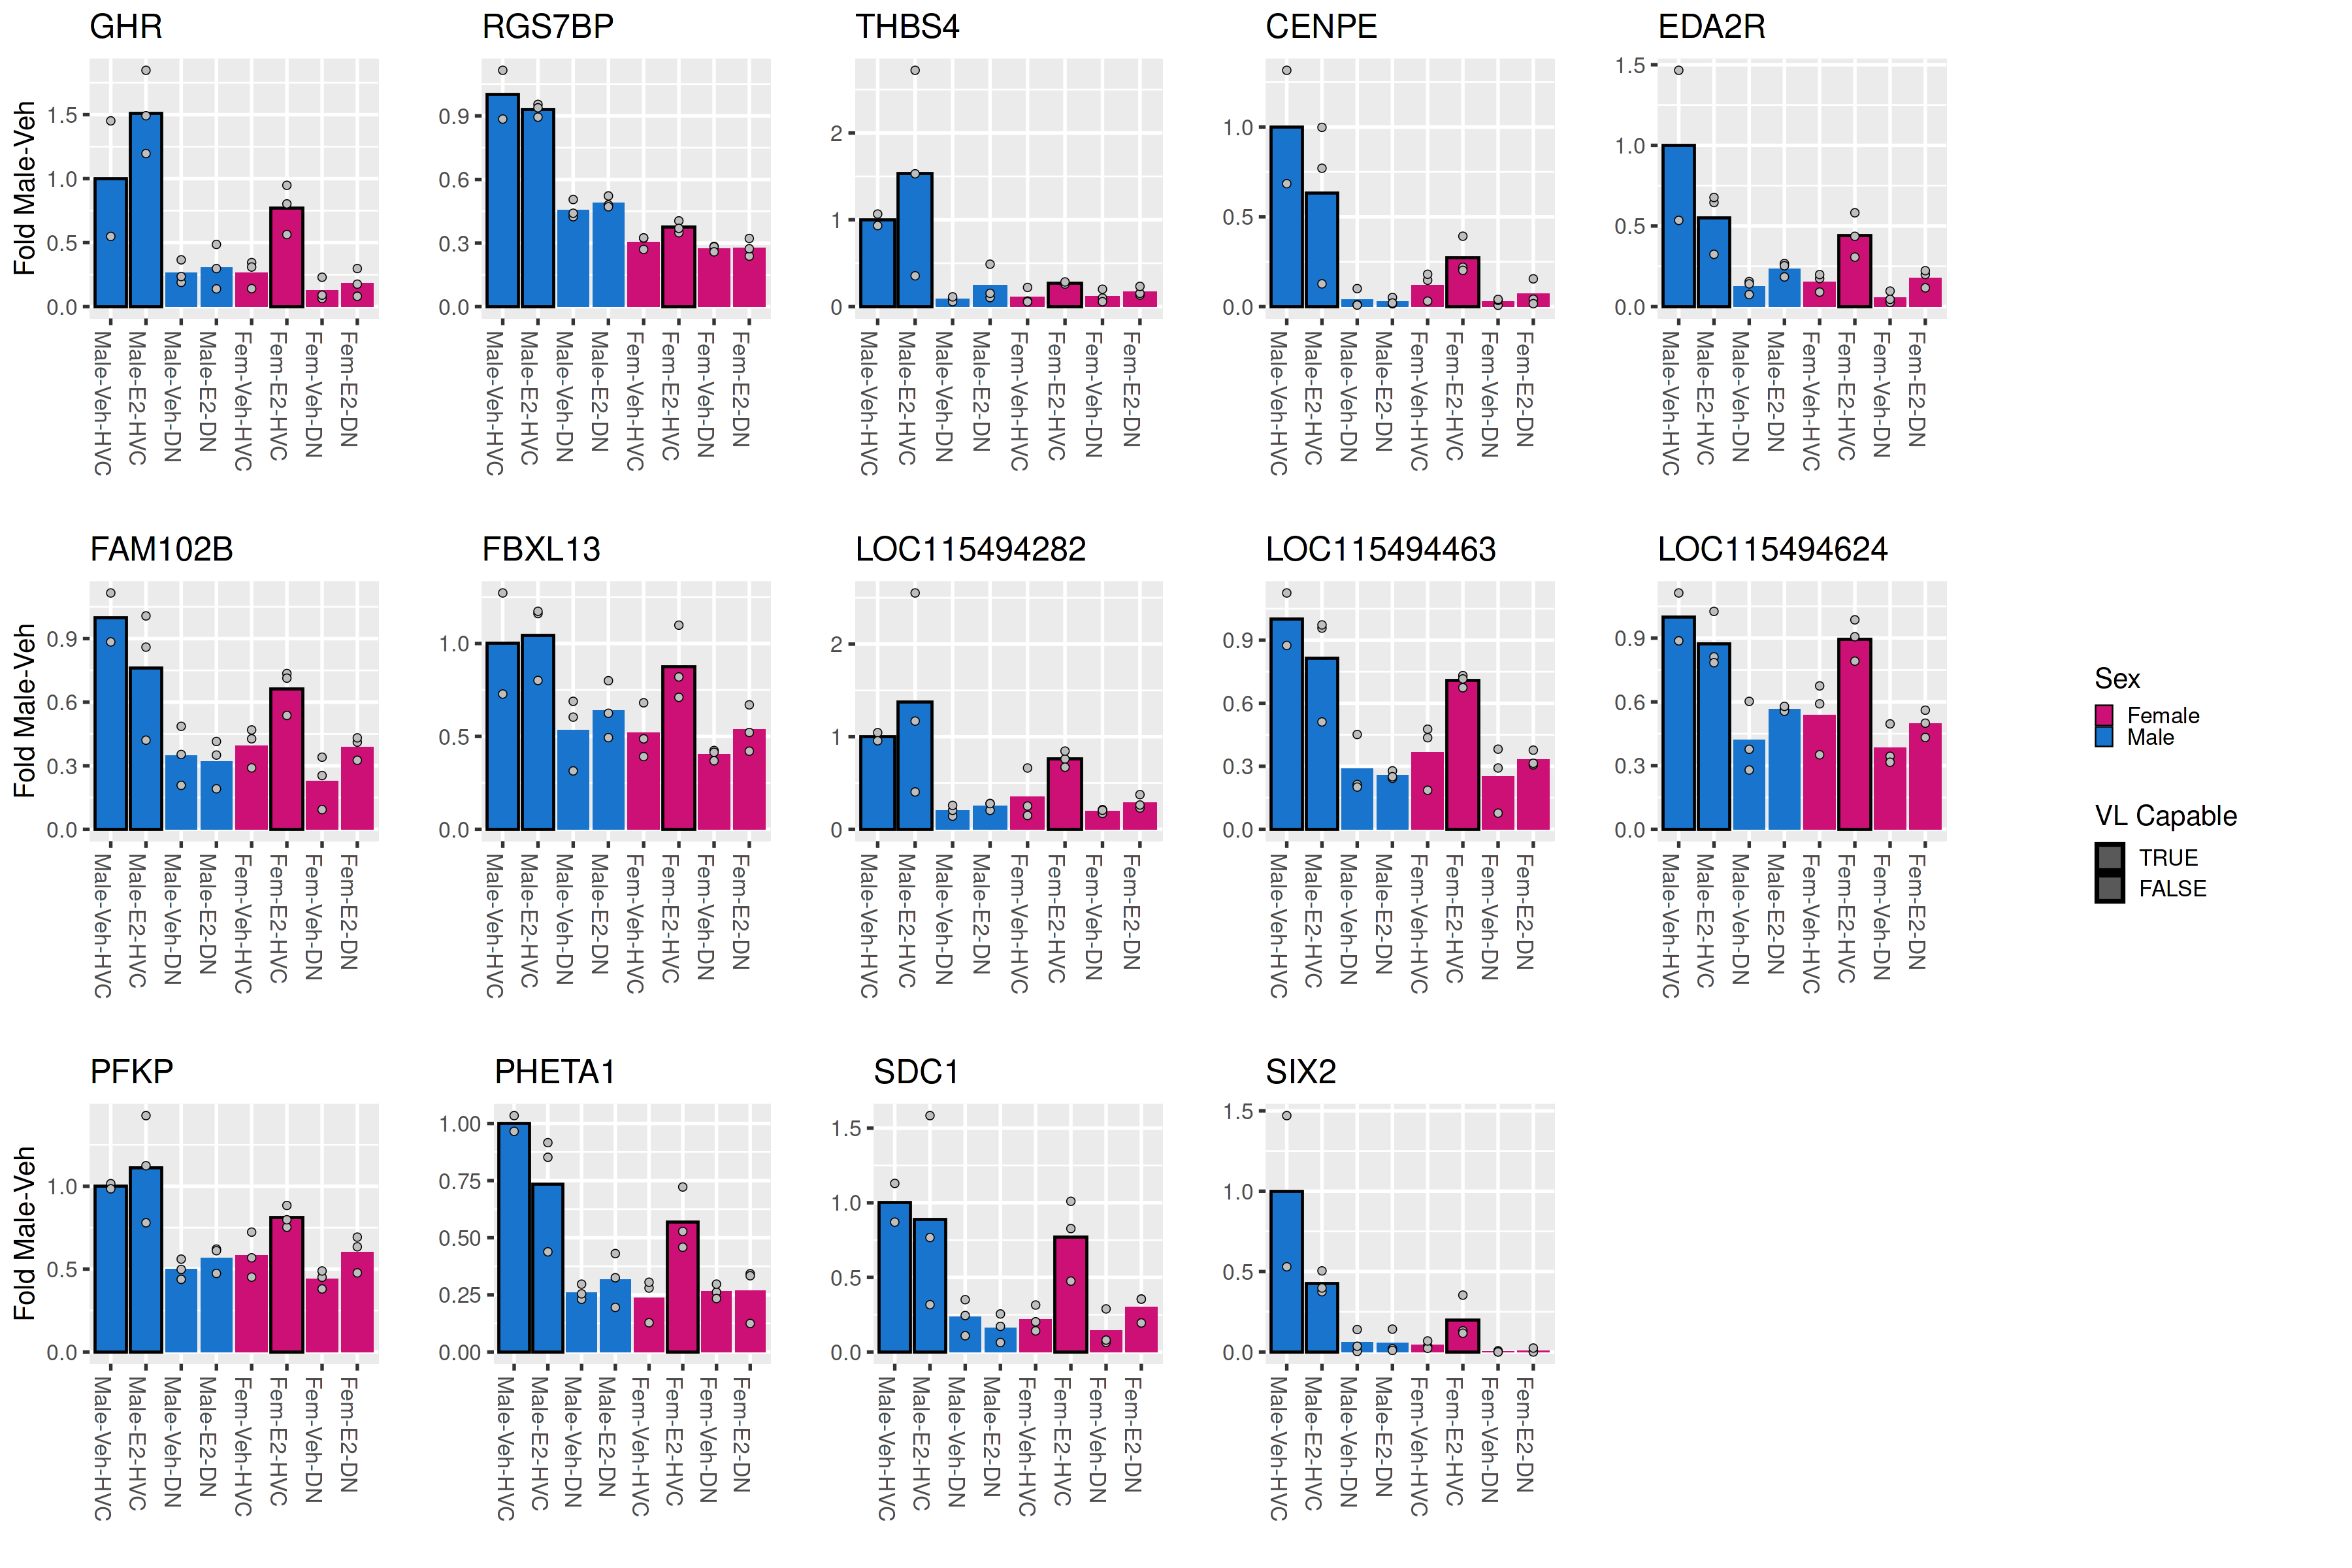

In [58]:
options(repr.plot.width=30, repr.plot.height=20)

names(core_genes) <- core_genes
plts<-core_genes %>% lapply(function(gen){
    tmp<-fpkm %>% filter(node=='dn') %>% filter(gene_id==gen) %>% mutate(grouping = paste(sex,dose,region,sep='_')) 
    male_veh_mean <- tmp %>% filter(grouping=='m_v_hvc') 
    male_veh_mean <- mean(male_veh_mean$fpkm)
    tmp<-tmp %>% mutate(norm_expr = fpkm/male_veh_mean) %>% mutate(grouping=grouping%>%as.factor)
    
    tmp$grouping <- factor(tmp$grouping,c('m_v_hvc','m_e_hvc','m_v_pln','m_e_pln',
                                          'f_v_hvc','f_e_hvc','f_v_pln','f_e_pln'))
    
    ggplot(tmp,aes(x=grouping,y=norm_expr,fill=sex,size=song_capable)) + 
        geom_bar(stat = "summary",color='black')+
        scale_size_manual("VL Capable",values=c(0,1),labels=c('TRUE','FALSE'))+
        geom_point(shape=21,size=3,fill='grey') +theme_grey(base_size=25) + ggtitle(gen) + 
        xlab("") + ylab('') + scale_x_discrete(labels=c("Male-Veh-HVC",'Male-E2-HVC','Male-Veh-DN','Male-E2-DN',
                                                      "Fem-Veh-HVC",'Fem-E2-HVC','Fem-Veh-DN','Fem-E2-DN')) +
        theme(axis.text.x=element_text(angle = -90, hjust = 0)) + 
        scale_fill_manual(name='Sex',values=c('deeppink3','dodgerblue3'),labels=c('Female','Male'))+
        guides(size = guide_legend(override.aes = list(size=10)))
    
})

lgnd <- g_legend(plts$GHR)

plts<-plts %>% lapply(function(plt){plt+theme(legend.position='none')})
row1<-ggarrange(plts$GHR+ylab('Fold Male-Veh'),plts$RGS7BP,plts$THBS4,plts$CENPE, plts$EDA2R,NULL,nrow=1,widths=c(1,1,1,1,1,1))
row2<-ggarrange(plts$FAM102B+ylab('Fold Male-Veh'),plts$FBXL13,plts$LOC115494282,plts$LOC115494463,plts$LOC115494624,lgnd,nrow=1,widths=c(1,1,1,1,1,1))
row3<-ggarrange(plts$PFKP+ylab('Fold Male-Veh'),plts$PHETA1,plts$SDC1,plts$SIX2,NULL,NULL, nrow=1,widths=c(1,1,1,1,1,1))
figs5_expression_bars<- ggarrange(row1,row2,row3,nrow=3)
figs5_expression_bars

ggsave(file='svg_files/figs5_expressionBars_remade.svg',plot=figs5_expression_bars, width = 30, height = 20)
#fpkm %>% filter(node=='dn') %>% filter(gene_id %in% core_genes)

In [42]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 22.04.1 LTS

Matrix products: default
BLAS:   /home/mdavenport/bin/R4.2.1/R-4.2.1/lib/libRblas.so
LAPACK: /home/mdavenport/bin/R4.2.1/R-4.2.1/lib/libRlapack.so

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] VennDiagram_1.7.3     futile.logger_1.4.3   ggrepel_0.9.1        
 [4] ggpubr_0.4.0          WGCNA_1.71            fastcluster_1.2.3    
 [7] dynamicTreeCut_1.63-1 forcats_0.5.2         stringr_1.4.1        
[10] dplyr_1.0.10          purrr_0.3.5           readr_2.1.3          
[13] tidyr_1.2.1      